# Brain Tumor Classification Task
Alessio Carnevale, Manuel Cattoni, Carlo Schillaci

Dataset link: [Kaggle](https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation/data)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import skimage
from functions import display_images_by_category, display_image_with_annotations, display_images_with_coco_annotations, visualize_annotation_mask, create_mask, sample_annotation_mask_pixels, extract_patches
from skimage import io
import os
import kagglehub
import random
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from tensorflow import keras


In [2]:
# Download latest version
path = kagglehub.dataset_download("pkdarabi/brain-tumor-image-dataset-semantic-segmentation")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\manuc\.cache\kagglehub\datasets\pkdarabi\brain-tumor-image-dataset-semantic-segmentation\versions\1


In [3]:
# Load the annotations file
with open('Dataset/train/_annotations.coco.json', 'r') as file:
    annotations = json.load(file)

# Print the JSON content in a readable format
print(json.dumps(annotations, indent=4))

{
    "info": {
        "year": "2023",
        "version": "1",
        "description": "Exported from roboflow.com",
        "contributor": "",
        "url": "https://public.roboflow.com/object-detection/undefined",
        "date_created": "2023-08-19T04:37:54+00:00"
    },
    "licenses": [
        {
            "id": 1,
            "url": "https://creativecommons.org/licenses/by/4.0/",
            "name": "CC BY 4.0"
        }
    ],
    "categories": [
        {
            "id": 0,
            "name": "Tumor",
            "supercategory": "none"
        },
        {
            "id": 1,
            "name": "0",
            "supercategory": "Tumor"
        },
        {
            "id": 2,
            "name": "1",
            "supercategory": "Tumor"
        }
    ],
    "images": [
        {
            "id": 0,
            "license": 1,
            "file_name": "2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg",
            "height": 640,
            "width": 640,
            "da

In [4]:
with open('Dataset/train/_annotations.coco.json','r') as file:
    train = json.load(file)

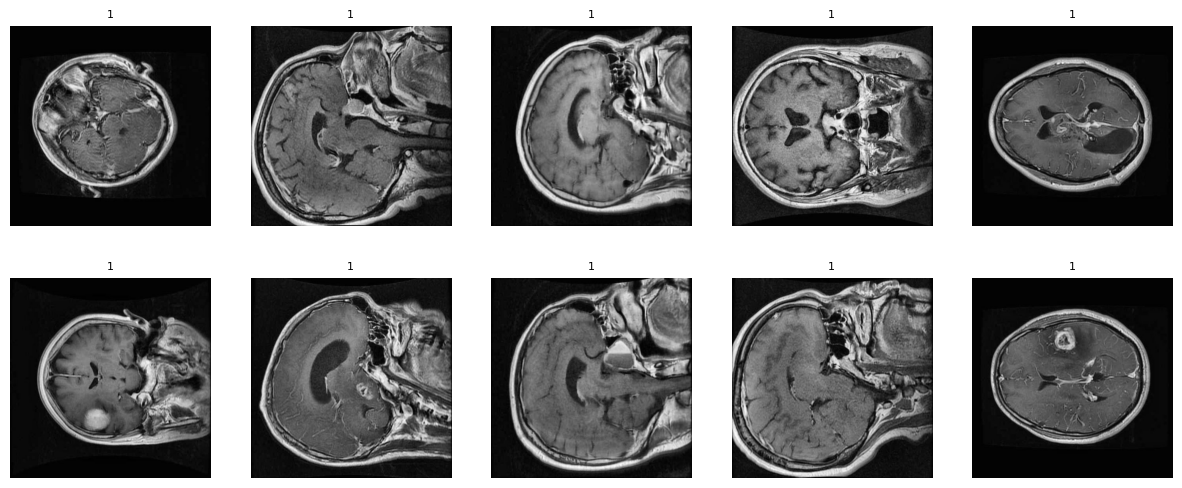

In [5]:
random_images = random.sample(train['images'], 10)

plt.figure(figsize=(15, 6))

for i, img_info in enumerate(random_images):
    img_path = os.path.join('Dataset/train', img_info['file_name'])
    
    img = io.imread(img_path)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(img_info['license'], fontsize=8)
    plt.axis('off')

plt.show()

JSON description for 1397_jpg.rf.0dd160fe65b4e1b932d858bde5e7b2a9.jpg:
{'id': 882, 'license': 1, 'file_name': '1397_jpg.rf.0dd160fe65b4e1b932d858bde5e7b2a9.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}
JSON description for 1218_jpg.rf.22521419bf854dc2406695d58a262627.jpg:
{'id': 991, 'license': 1, 'file_name': '1218_jpg.rf.22521419bf854dc2406695d58a262627.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}
JSON description for 1050_jpg.rf.1cb3e5e621712f18f7669082cdc37794.jpg:
{'id': 960, 'license': 1, 'file_name': '1050_jpg.rf.1cb3e5e621712f18f7669082cdc37794.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}
JSON description for 1935_jpg.rf.e2c70704409002145c8abc2136e7f293.jpg:
{'id': 467, 'license': 1, 'file_name': '1935_jpg.rf.e2c70704409002145c8abc2136e7f293.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}
JSON description for 2680_jpg.rf.7ab29b44fb8f38a1a75

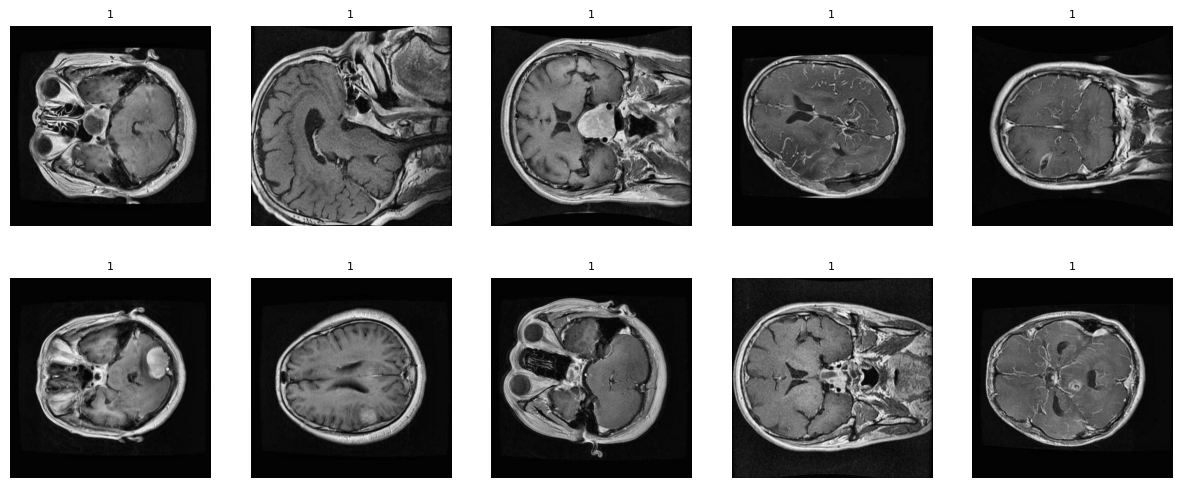

In [6]:
random_images = random.sample(train['images'], 10)

plt.figure(figsize=(15, 6))

for i, img_info in enumerate(random_images):
    img_path = os.path.join('Dataset/train', img_info['file_name'])
    
    img = io.imread(img_path)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(img_info['license'], fontsize=8)
    plt.axis('off')

    # Print the full JSON description for the image
    print(f"JSON description for {img_info['file_name']}:")
    print(img_info)

plt.show()

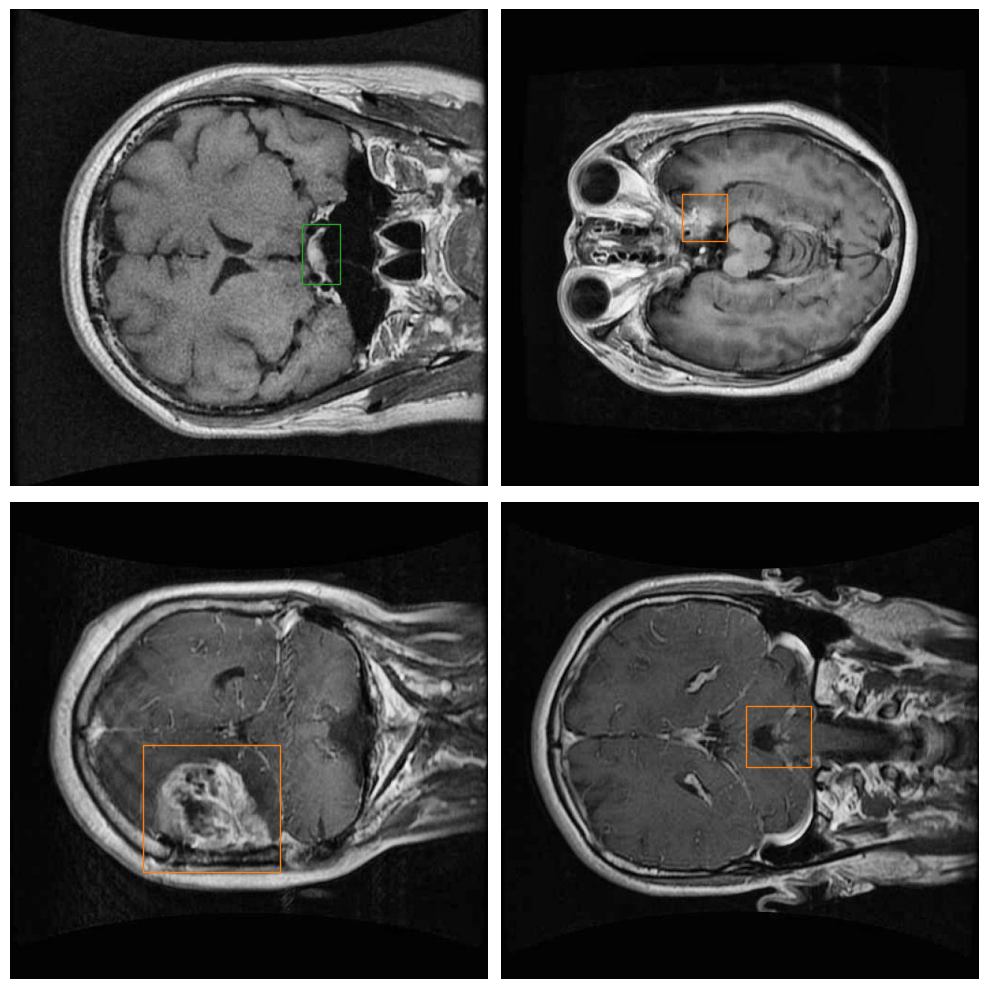

In [7]:
all_image_files = [os.path.join('Dataset/train', img['file_name']) for img in train['images']]
random_image_files = random.sample(all_image_files, 4)

# Choose between 'bbox', 'seg', or 'both'
display_type = 'seg'
display_images_with_coco_annotations(random_image_files, train, display_type)

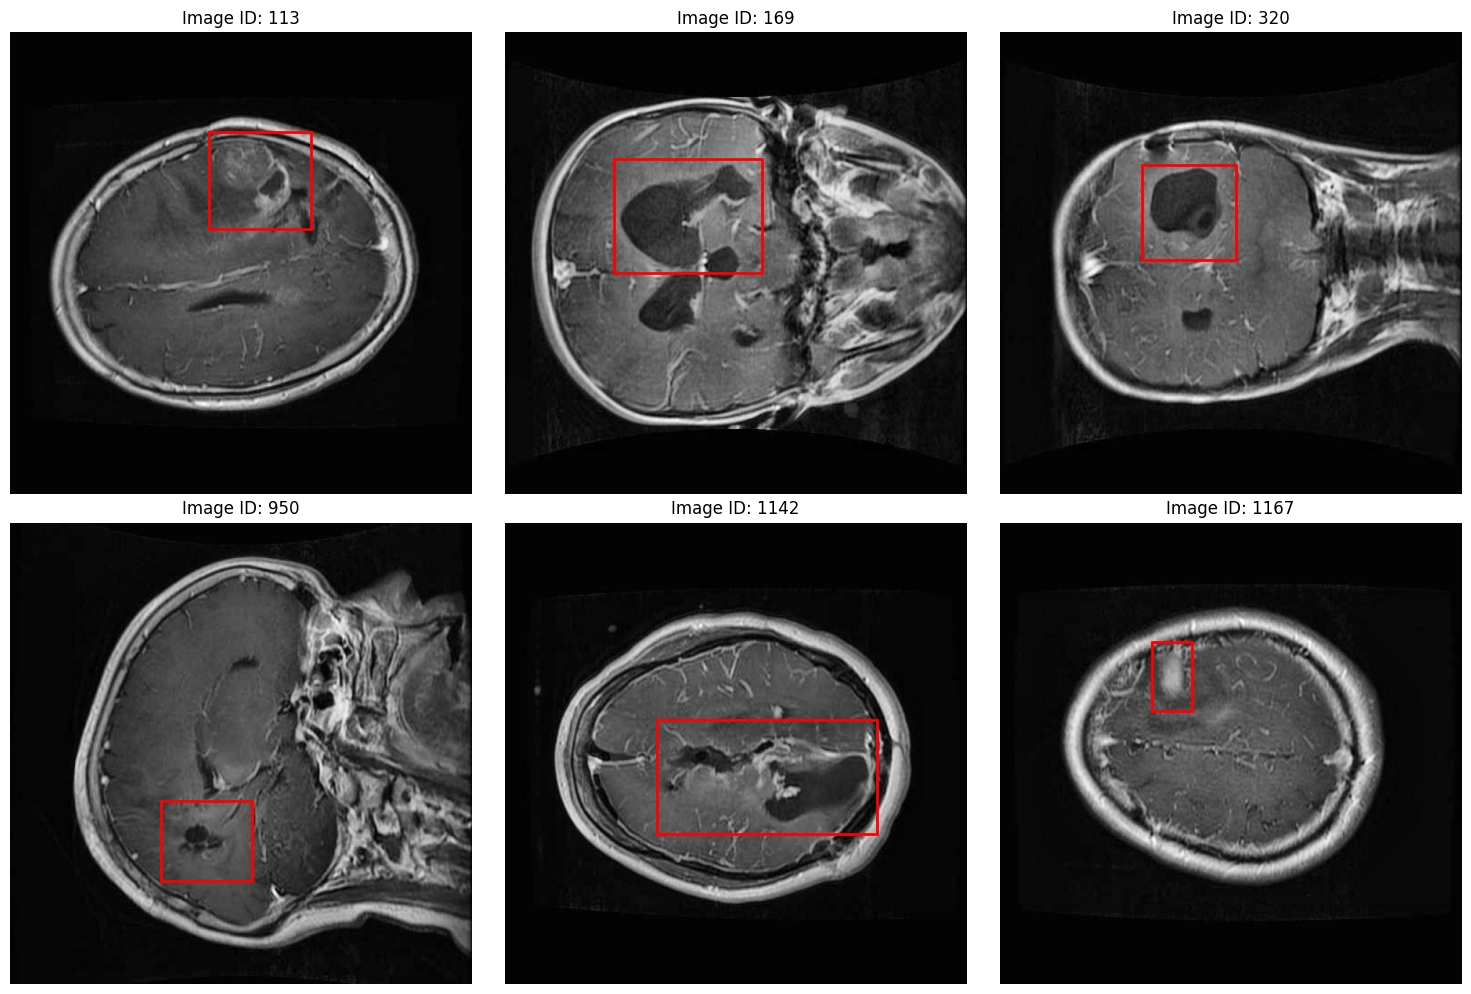

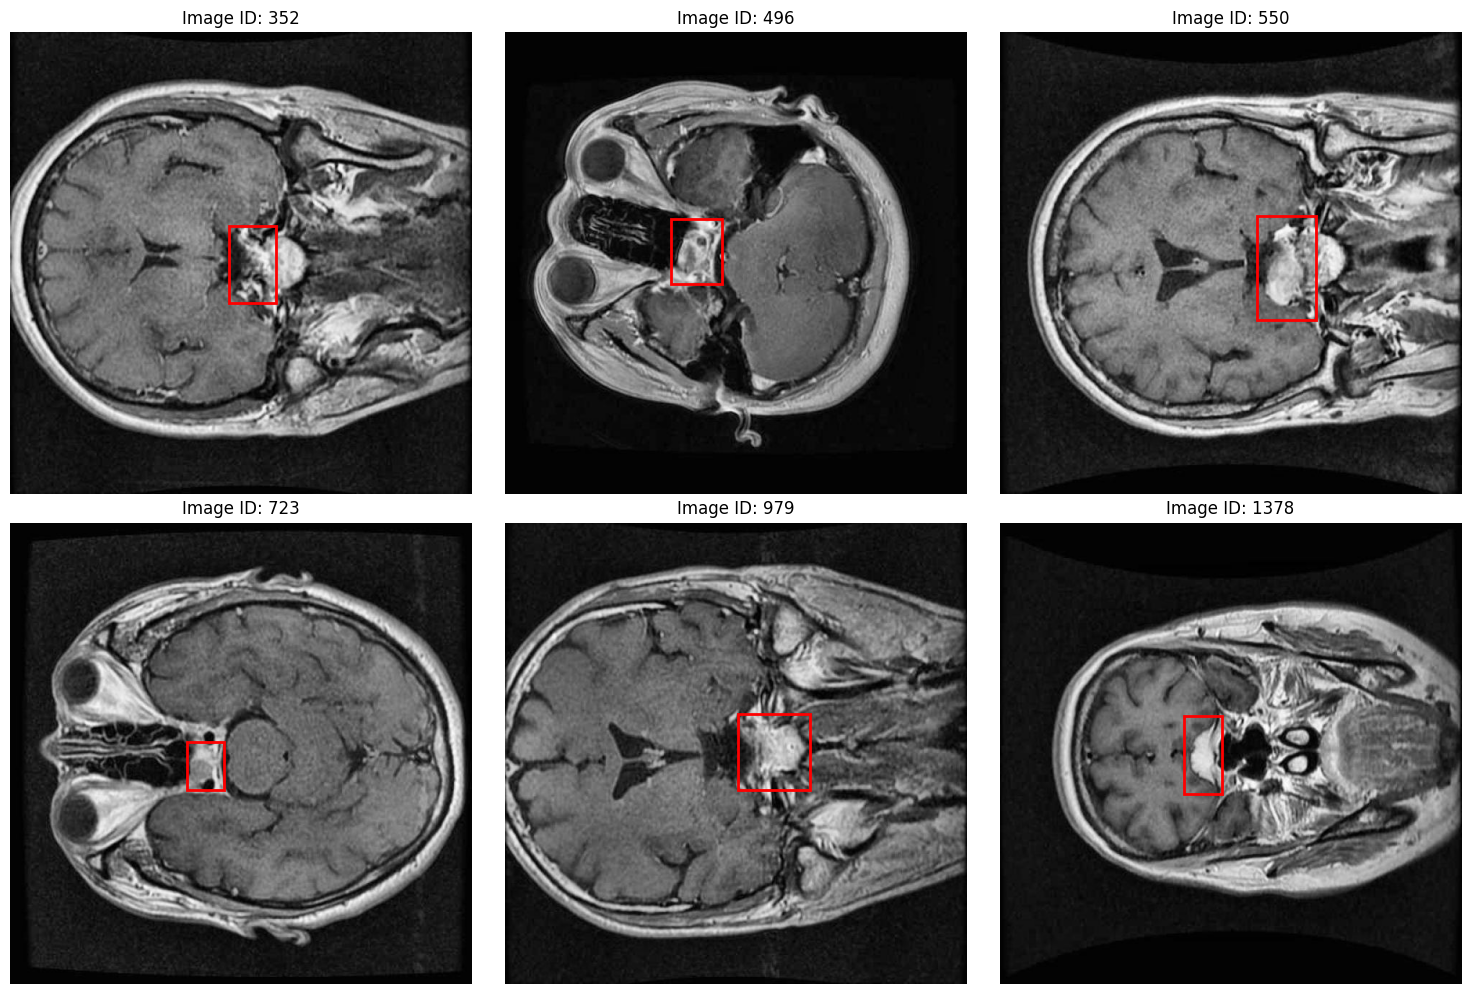

In [8]:
# Display 5 random images for category_id = 1
display_images_by_category(train, category_id=1, num_images=6)

# Display 5 random images for category_id = 2
display_images_by_category(train, category_id=2, num_images=6)

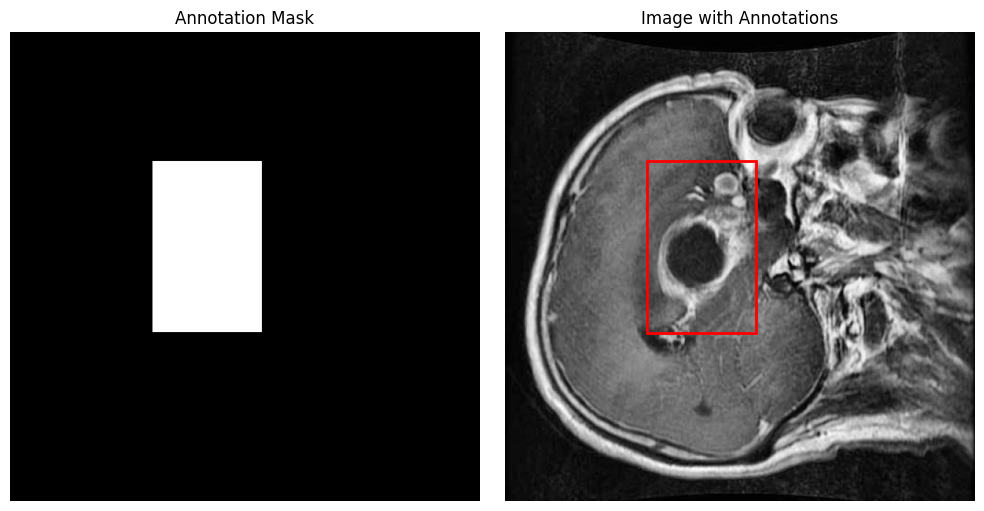

In [9]:
# Example usage
visualize_annotation_mask(train, image_id=1, show_annotations=True)

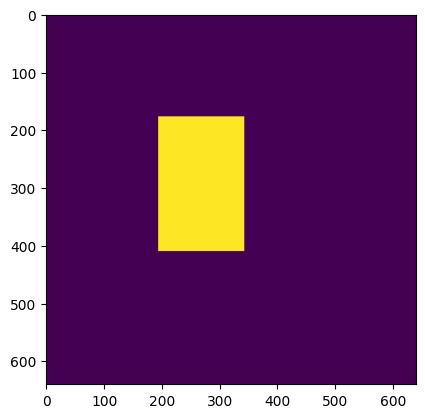

In [10]:
test_mask = create_mask(train, image_id=1)
plt.imshow(test_mask)

# Create patches

### only with 20 images

In [11]:
image_id = 1
patches_total = []
labels_total = []

for img_id in range(len(train['images'][:20])):
    patches, labels = extract_patches(annotations, image_id)
    patches_total.extend(patches)
    labels_total.extend(labels)

since a lot of non tumors have black background, we filter them based on the mean and std.dev. intensity

Tumor patches: 20
Non-tumor patches: 20


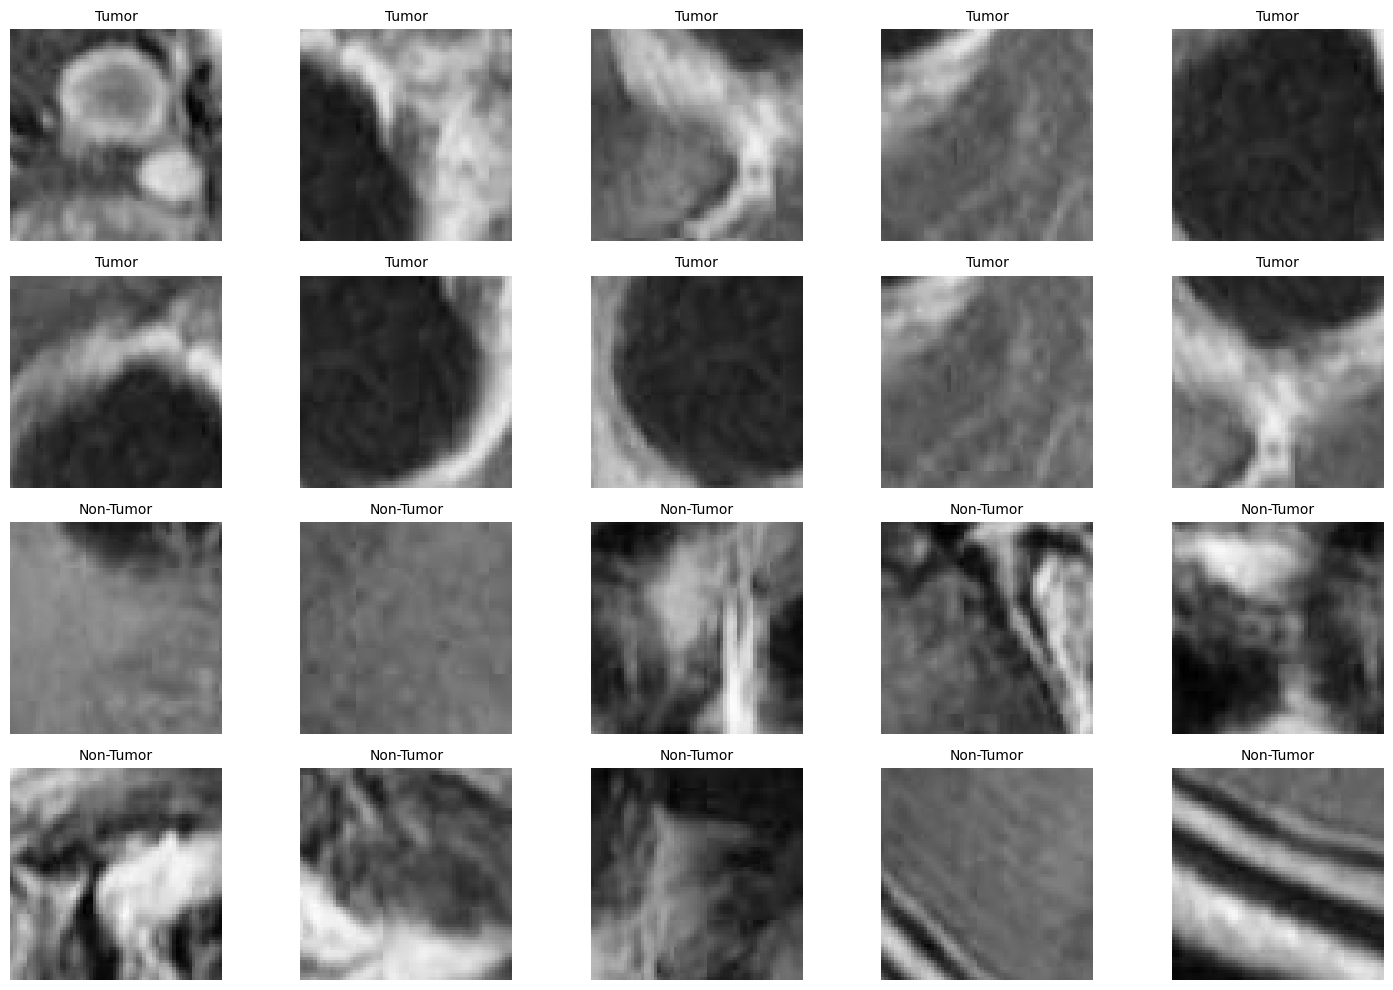

In [12]:
# Separates tumor and non-tumor patches
tumor_patches = [patch for patch, label in zip(patches_total, labels_total) 
                 if isinstance(patch, np.ndarray) and patch.size > 0 and label == 255]
non_tumor_patches = [patch for patch, label in zip(patches_total, labels_total) 
                     if isinstance(patch, np.ndarray) and patch.size > 0 and label != 255]

# Filters non-informative patches (too dark)
def is_informative(patch):
    return patch.mean() > 30 and patch.std() > 15

filtered_tumor = [p for p in tumor_patches if is_informative(p)]
filtered_non_tumor = [p for p in non_tumor_patches if is_informative(p)]

print(f"Tumor patches: {len(tumor_patches)}")
print(f"Non-tumor patches: {len(non_tumor_patches)}")

# Selects 10 random patches from each category
k_tumor = min(10, len(tumor_patches))
k_non_tumor = min(10, len(non_tumor_patches))

if k_tumor > 0 and k_non_tumor > 0:
    random_tumor_patches = random.sample(tumor_patches, k_tumor)
    random_non_tumor_patches = random.sample(non_tumor_patches, k_non_tumor)

    # Visualizes the patches
    plt.figure(figsize=(15, 10))

    # Plot tumor patches
    for i, patch in enumerate(random_tumor_patches):
        plt.subplot(4, 5, i + 1)
        plt.imshow(patch, cmap="gray")
        plt.title("Tumor", fontsize=10)
        plt.axis('off')

    # Plot non-tumor patches
    for i, patch in enumerate(random_non_tumor_patches):
        plt.subplot(4, 5, i + 11)
        plt.imshow(patch, cmap="gray")
        plt.title("Non-Tumor", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("There are not enough valid patches for visualization.")


# Build Training Dataset 

## Build and save the data

In [13]:
# # Create a dataset of patches from all images in the training set
# patches_train = []
# labels_train = []

# for img_info in train['images']:
#     img_id = img_info['id']
#     print(f"Processing image {img_id}...")
    
#     try:
#         patches, labels = extract_patches(train, img_id)
#         patches_train.extend(patches)
#         labels_train.extend(labels)
#     except Exception as e:
#         print(f"Error processing image {img_id}: {e}")
#         continue

# print(f"\nTotal patches extracted: {len(patches_train)}")
# print(f"Total labels: {len(labels_train)}")

In [14]:
# # Filter out non-informative patches (too dark)
# def is_informative(patch):
#     return patch.mean() > 30 and patch.std() > 15

# filtered_tumor = [p for p in tumor_patches if is_informative(p)]
# filtered_non_tumor = [p for p in non_tumor_patches if is_informative(p)]

In [15]:
# X_train = filtered_tumor + filtered_non_tumor
# y_train = [1] * len(filtered_tumor) + [0] * len(filtered_non_tumor)

In [16]:
# np.savez_compressed('patches_train.npz',
#                     X_train=np.array(X_train),
#                     y_train=np.array(y_train))

## Extract the data

In [17]:
data = np.load('patches_train.npz')
X_train = data['X_train']
y_train = data['y_train']

In [18]:
X_train_norm = X_train.astype('float32') / 255.0

# Train a classifier 

In [19]:
# Flatten patches for logistic regression
X_train_flat = np.array([p.flatten() for p in X_train_norm])
y_train = np.array(y_train)

# Train
logistic = LogisticRegression(max_iter=1000)
logistic.fit(X_train_flat, y_train)

LogisticRegression(max_iter=1000)

# Evaluate on validation patches

## Create right validation

In [20]:
with open('Dataset/valid/_annotations.coco.json','r') as file:
    valid = json.load(file)

In [21]:
# # Create a dataset of patches from all images in the validation set.
# valid_patches = []
# valid_labels = []

# for img_info in valid['images']:
#     img_id = img_info['id']
#     print(f"Processing image {img_id}...")
    
#     try:
#         patches, labels = extract_patches(valid, img_id, "valid")
#         valid_patches.extend(patches)
#         valid_labels.extend(labels)
#     except Exception as e:
#         print(f"Error processing image {img_id}: {e}")
#         continue

# print(f"\nTotal patches extracted: {len(valid_patches)}")
# print(f"Total labels: {len(valid_labels)}")

# valid_tumor_patches = [patch for patch, label in zip(valid_patches, valid_labels) 
#                  if isinstance(patch, np.ndarray) and patch.size > 0 and label == 255]
# valid_non_tumor_patches = [patch for patch, label in zip(valid_patches, valid_labels) 
#                      if isinstance(patch, np.ndarray) and patch.size > 0 and label != 255]


In [22]:
# X_valid = valid_tumor_patches + valid_non_tumor_patches
# y_valid = [1] * len(valid_tumor_patches) + [0] * len(valid_non_tumor_patches)

# X_valid_flat = np.array([p.flatten() for p in X_valid])
# y_valid = np.array(y_valid) 

# np.savez_compressed('patch_valid.npz',
#                     X_valid=np.array(X_valid),
#                     y_valid=np.array(y_valid))

## Upload

In [23]:
data = np.load('patch_valid.npz')
X_valid = data['X_valid']
y_valid = data['y_valid']

In [24]:
X_valid_norm = X_valid.astype('float32') / 255.0

Accuracy: 0.5902
------------------------------
Classification Report:
              precision    recall  f1-score   support

   Non-Tumor       0.62      0.59      0.60       429
       Tumor       0.56      0.59      0.58       386

    accuracy                           0.59       815
   macro avg       0.59      0.59      0.59       815
weighted avg       0.59      0.59      0.59       815



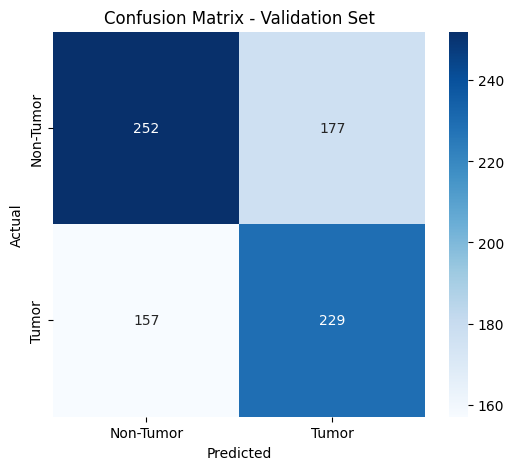

In [25]:
# 2. Make predictions using the trained model

X_valid_flat = np.array([p.flatten() for p in X_valid_norm])

y_pred = logistic.predict(X_valid_flat)

# 3. Calculate and print metrics
acc = accuracy_score(y_valid, y_pred)
print(f"Accuracy: {acc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_valid, y_pred, target_names=['Non-Tumor', 'Tumor']))

# 4. Visualize the Confusion Matrix 
cm = confusion_matrix(y_valid, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Tumor', 'Tumor'], 
            yticklabels=['Non-Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set')

plt.show()

## CNN

In [26]:
# Build a CNN using Keras

# Build the CNN model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train[0].shape),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_norm, y_train,
    validation_data=(X_valid_norm, y_valid),
    epochs=10,
    batch_size=32
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_valid_norm, y_valid, verbose=0)

print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

c:\Users\manuc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.6706 - loss: 0.6806 - val_accuracy: 0.4736 - val_loss: 0.9177
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7394 - loss: 0.5227 - val_accuracy: 0.4834 - val_loss: 0.7697
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7841 - loss: 0.4583 - val_accuracy: 0.5448 - val_loss: 0.7625
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7912 - loss: 0.4392 - val_accuracy: 0.5546 - val_loss: 0.6926
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7803 - loss: 0.4537 - val_accuracy: 0.6061 - val_loss: 0.7891
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8144 - loss: 0.4167 - val_accuracy: 0.6908 - val_loss: 0.5948
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.8250 - loss: 0.3731 - val_accuracy: 0.7509 - val_loss: 0.4642
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8566 - loss: 0.3233 - val_accuracy: 0.7902 - v

# Use the test set on the Logistic and CNN

## Extracting test set

In [27]:
with open('Dataset/test/_annotations.coco.json','r') as file:
    test = json.load(file)

In [28]:
# # Create a dataset of patches from all images in the test set
# patches_test = []
# labels_test = []

# for img_info in test['images']:
#     img_id = img_info['id']
#     print(f"Processing image {img_id}...")
    
#     try:
#         patches, labels = extract_patches(test, img_id, "test")
#         patches_test.extend(patches)
#         labels_test.extend(labels)
#     except Exception as e:
#         print(f"Error processing image {img_id}: {e}")
#         continue

# print(f"\nTotal patches extracted: {len(patches_test)}")
# print(f"Total labels: {len(labels_test)}")

# test_tumor_patches = [patch for patch, label in zip(patches_test, labels_test) 
#                  if isinstance(patch, np.ndarray) and patch.size > 0 and label == 255]
# test_non_tumor_patches = [patch for patch, label in zip(patches_test, labels_test) 
#                      if isinstance(patch, np.ndarray) and patch.size > 0 and label != 255]

In [29]:
# X_test = test_tumor_patches + test_non_tumor_patches
# y_test = [1] * len(test_tumor_patches) + [0] * len(test_non_tumor_patches)

# X_test_flat = np.array([p.flatten() for p in X_test])
# y_test = np.array(y_test) 

# np.savez_compressed('patch_test.npz',
#                     X_test=np.array(X_test),
#                     y_test=np.array(y_test))

In [30]:
data = np.load('patch_test.npz')
X_test = data['X_test']
y_test = data['y_test']

## Logistic

Accuracy: 0.5945
------------------------------
Classification Report:
              precision    recall  f1-score   support

   Non-Tumor       0.64      0.56      0.60       215
       Tumor       0.56      0.63      0.59       187

    accuracy                           0.59       402
   macro avg       0.60      0.60      0.59       402
weighted avg       0.60      0.59      0.59       402



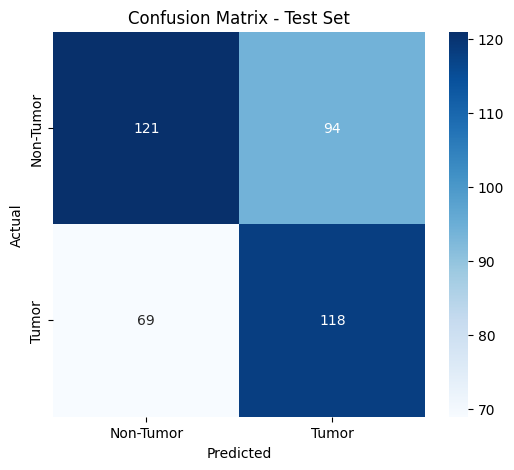

In [31]:
# 2. Make predictions using the trained model

X_test_norm = X_test.astype('float32') / 255.0

X_test_flat = np.array([p.flatten() for p in X_test_norm])

y_pred = logistic.predict(X_test_flat)  

# 3. Calculate and print metrics
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Tumor', 'Tumor']))

# 4. Visualize the Confusion Matrix 
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Tumor', 'Tumor'], 
            yticklabels=['Non-Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')  

plt.show()

## CNN

In [32]:
test_loss, test_accuracy = model.evaluate(X_test_norm, y_test, verbose=0)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss: 0.44971615076065063, Test Accuracy: 0.7711442708969116
